# Graph_Data_Clean_Separate

### This notebook extracts the MTA turnstile data file. Stations and linenames are modified to match one  
### format to be grouped together. The daily totals by turnstiles dataset is used throughout the notebook
### for data transformation and plotting. This dataset is cleaned for outliers before plotting. The main 
### function after the ETL is to plot the Top 20 stations in terms of entries, exits and total foot traffic.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# extract the NYC MTA dataset for the week of May 4, 11, 18, 25 in 2019

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190525, 190518, 190511, 190504]
df = get_data(week_nums)

In [3]:
# remove the blanks in column name
df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [4]:
# create Date_Time feature
df['Date_Time'] = df['DATE'] + ' ' + df['TIME']

In [5]:
# convert string Date_Time to datetime format
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

In [6]:
# subset data to only REGULAR in DESC (descriptions)
df = df[df['DESC'] == 'REGULAR']

In [7]:
## gets the count of entries and exits by using max counter - min counter per day per turnstile
mta_entries = df.groupby(['STATION','C/A','UNIT','SCP','DATE', 'LINENAME']).ENTRIES.max() - df.groupby(['STATION','C/A','UNIT','SCP','DATE', 'LINENAME']).ENTRIES.min()
mta_exits = df.groupby(['STATION','C/A','UNIT','SCP','DATE', 'LINENAME']).EXITS.max() - df.groupby(['STATION','C/A','UNIT','SCP','DATE', 'LINENAME']).EXITS.min()

## resetting index of the data
mta_entries_flat = mta_entries.reset_index()
mta_exits_flat = mta_exits.reset_index()
mta_entries_exits = pd.merge(mta_entries_flat, mta_exits_flat, how='outer')

In [9]:
# we observed outliers in our data with can skew the result set.
# so we chose to use the quantile function for 99.9% to eliminate outliers
mta_entries_exits.ENTRIES.quantile(.999)

mta_entries_exits.EXITS.quantile(.999)

9242.350000000122

In [10]:
# remove data greater than the 99.9% quantile
mta_traffic = mta_entries_exits[(mta_entries_exits['ENTRIES']<10000) & (mta_entries_exits['EXITS']<10000) & (mta_entries_exits['ENTRIES'] > 1) & (mta_entries_exits['EXITS'] > 1)]

In [11]:
# sum all the data by Station and Linename
mta_station_rank = mta_traffic.groupby(['STATION', 'LINENAME']).sum()

In [12]:
mta_station_rank

ENTRIES   EXITS
STATION         LINENAME                 
1 AV            L          371519  424933
103 ST          1          298380  136534
                6          314527  268778
                BC         120371   71743
103 ST-CORONA   7          481403  289214
...                           ...     ...
WOODLAWN        4          159155   33326
WORLD TRADE CTR ACE23      398303  326548
WTC-CORTLANDT   1          300175  237034
YORK ST         F          294509  142730
ZEREGA AV       6           62168   53485

[475 rows x 2 columns]

In [13]:
# display the top 30
mta_rank = mta_station_rank.sort_values(by='ENTRIES', ascending = False).head(30).reset_index()
mta_rank

,STATION,LINENAME,ENTRIES,EXITS
0,GRD CNTRL-42 ST,4567S,3224858,2863898
1,34 ST-HERALD SQ,BDFMNQRW,2627237,2588666
2,42 ST-PORT AUTH,ACENQRS1237W,2004266,1440970
3,34 ST-PENN STA,ACE,1839176,1694198
4,14 ST-UNION SQ,LNQR456W,1557169,1529219
5,FULTON ST,2345ACJZ,1397913,1403868
6,TIMES SQ-42 ST,1237ACENQRSW,1354194,1467921
7,59 ST COLUMBUS,ABCD1,1266615,1139871
8,FLUSHING-MAIN,7,1258999,957407
9,47-50 STS ROCK,BDFM,1243351,1441104


In [14]:
# flattens file. makes Station and Linename data columns
mta_station_rank_new = mta_station_rank.reset_index()
mta_station_rank_new

,STATION,LINENAME,ENTRIES,EXITS
0,1 AV,L,371519,424933
1,103 ST,1,298380,136534
2,103 ST,6,314527,268778
3,103 ST,BC,120371,71743
4,103 ST-CORONA,7,481403,289214
...,...,...,...,...
470,WOODLAWN,4,159155,33326
471,WORLD TRADE CTR,ACE23,398303,326548
472,WTC-CORTLANDT,1,300175,237034
473,YORK ST,F,294509,142730


### The following lines of code matches inconsistent Station Linenames to the correct Stations and Linenames

In [15]:
mta_station_rank_new[mta_station_rank_new['STATION'] == '34 ST-PENN STA']

,STATION,LINENAME,ENTRIES,EXITS
91,34 ST-PENN STA,123,767792,799383
92,34 ST-PENN STA,123ACE,1175761,1045000
93,34 ST-PENN STA,ACE,1839176,1694198


In [16]:
mta_station_rank_new.iloc[91, mta_rank.columns.get_loc('LINENAME')] = '123ACE'

In [17]:
mta_station_rank_new.iloc[93, mta_rank.columns.get_loc('LINENAME')] = '123ACE'

In [18]:
mta_station_rank_new[mta_station_rank_new['STATION'] == '42 ST-PORT AUTH']

,STATION,LINENAME,ENTRIES,EXITS
101,42 ST-PORT AUTH,ACENGRS1237W,301006,332118
102,42 ST-PORT AUTH,ACENQRS1237W,2004266,1440970


In [19]:
mta_station_rank_new.iloc[101, mta_rank.columns.get_loc('LINENAME')] = 'ACENQRS1237W'

In [20]:
mta_station_rank_new[mta_station_rank_new['STATION'] == '14 ST-UNION SQ']

,STATION,LINENAME,ENTRIES,EXITS
26,14 ST-UNION SQ,456LNQRW,701611,758597
27,14 ST-UNION SQ,LNQR456W,1557169,1529219


In [21]:
mta_station_rank_new.iloc[26, mta_rank.columns.get_loc('LINENAME')] = 'LNQR456W'

In [22]:
mta_station_rank_new[mta_station_rank_new['STATION'] == 'FULTON ST']

,STATION,LINENAME,ENTRIES,EXITS
301,FULTON ST,2345ACJZ,1397913,1403868
302,FULTON ST,ACJZ2345,682357,385929
303,FULTON ST,G,126665,100373


In [23]:
mta_station_rank_new.iloc[302, mta_rank.columns.get_loc('LINENAME')] = '2345ACJZ'

In [24]:
mta_station_rank_new[mta_station_rank_new['STATION'] == 'TIMES SQ-42 ST']

,STATION,LINENAME,ENTRIES,EXITS
445,TIMES SQ-42 ST,1237ACENQRS,348966,189112
446,TIMES SQ-42 ST,1237ACENQRSW,1354194,1467921
447,TIMES SQ-42 ST,ACENQRS1237W,323188,486087


In [25]:
mta_station_rank_new.iloc[445, mta_rank.columns.get_loc('LINENAME')] = '1237ACENQRSW'

In [26]:
mta_station_rank_new.iloc[447, mta_rank.columns.get_loc('LINENAME')] = '1237ACENQRSW'

In [27]:
mta_station_rank_new[mta_station_rank_new['STATION'] == '59 ST COLUMBUS']

,STATION,LINENAME,ENTRIES,EXITS
124,59 ST COLUMBUS,1ABCD,305954,262047
125,59 ST COLUMBUS,ABCD1,1266615,1139871


In [28]:
mta_station_rank_new.iloc[125, mta_rank.columns.get_loc('LINENAME')] = 'ABCD1'

In [29]:
mta_station_rank_new[mta_station_rank_new['STATION'] == '59 ST']

,STATION,LINENAME,ENTRIES,EXITS
121,59 ST,456NQRW,881472,1027828
122,59 ST,NQR456W,276845,185411
123,59 ST,NRW,275875,123216


In [30]:
mta_station_rank_new.iloc[122, mta_rank.columns.get_loc('LINENAME')] = '456NQRW'

In [31]:
mta_station_rank_new[mta_station_rank_new['STATION'] == 'BOROUGH HALL']

,STATION,LINENAME,ENTRIES,EXITS
213,BOROUGH HALL,2345R,722316,489791
214,BOROUGH HALL,R2345,60298,39398


In [32]:
mta_station_rank_new.iloc[214, mta_rank.columns.get_loc('LINENAME')] = '2345R'

In [33]:
mta_station_rank_new[mta_station_rank_new['STATION'] == '42 ST-PORT AUTH']

,STATION,LINENAME,ENTRIES,EXITS
101,42 ST-PORT AUTH,ACENQRS1237W,301006,332118
102,42 ST-PORT AUTH,ACENQRS1237W,2004266,1440970


In [34]:
mta_station_rank_new[mta_station_rank_new['STATION'] == 'TIMES SQ-42 ST']

,STATION,LINENAME,ENTRIES,EXITS
445,TIMES SQ-42 ST,1237ACENQRSW,348966,189112
446,TIMES SQ-42 ST,1237ACENQRSW,1354194,1467921
447,TIMES SQ-42 ST,1237ACENQRSW,323188,486087


In [37]:
# re-group by Station and Linename so they can be correctly summed up
mta_station_rank_by_linename = mta_station_rank_new.groupby(['STATION', 'LINENAME']).sum()
mta_station_rank_by_linename

ENTRIES   EXITS
STATION         LINENAME                 
1 AV            L          371519  424933
103 ST          1          298380  136534
                6          314527  268778
                BC         120371   71743
103 ST-CORONA   7          481403  289214
...                           ...     ...
WOODLAWN        4          159155   33326
WORLD TRADE CTR ACE23      398303  326548
WTC-CORTLANDT   1          300175  237034
YORK ST         F          294509  142730
ZEREGA AV       6           62168   53485

[466 rows x 2 columns]

In [38]:
# flatten file to make Station and Linename data columns
mta_rank_linename = mta_station_rank_by_linename.sort_values(by='ENTRIES', ascending = False).head(40).reset_index()
mta_rank_linename

,STATION,LINENAME,ENTRIES,EXITS
0,34 ST-PENN STA,123ACE,3782729,3538581
1,GRD CNTRL-42 ST,4567S,3224858,2863898
2,34 ST-HERALD SQ,BDFMNQRW,2627237,2588666
3,42 ST-PORT AUTH,ACENQRS1237W,2305272,1773088
4,14 ST-UNION SQ,LNQR456W,2258780,2287816
5,FULTON ST,2345ACJZ,2080270,1789797
6,TIMES SQ-42 ST,1237ACENQRSW,2026348,2143120
7,59 ST COLUMBUS,ABCD1,1266615,1139871
8,FLUSHING-MAIN,7,1258999,957407
9,47-50 STS ROCK,BDFM,1243351,1441104


In [39]:
# create TotTraf feature by summing Entries and Exits
mta_rank_linename['TotalTraf'] = mta_rank_linename['ENTRIES']  + mta_rank_linename['EXITS']
mta_rank_linename

,STATION,LINENAME,ENTRIES,EXITS,TotalTraf
0,34 ST-PENN STA,123ACE,3782729,3538581,7321310
1,GRD CNTRL-42 ST,4567S,3224858,2863898,6088756
2,34 ST-HERALD SQ,BDFMNQRW,2627237,2588666,5215903
3,42 ST-PORT AUTH,ACENQRS1237W,2305272,1773088,4078360
4,14 ST-UNION SQ,LNQR456W,2258780,2287816,4546596
5,FULTON ST,2345ACJZ,2080270,1789797,3870067
6,TIMES SQ-42 ST,1237ACENQRSW,2026348,2143120,4169468
7,59 ST COLUMBUS,ABCD1,1266615,1139871,2406486
8,FLUSHING-MAIN,7,1258999,957407,2216406
9,47-50 STS ROCK,BDFM,1243351,1441104,2684455


In [41]:
# sort by TotalTraf
mta_rank_linename.sort_values(by = 'TotalTraf', ascending = False)

In [42]:
# keep Top 20
mta_final_linename = mta_rank_linename.sort_values(by = 'TotalTraf', ascending = False).head(20)
mta_final_linename

,STATION,LINENAME,ENTRIES,EXITS,TotalTraf
0,34 ST-PENN STA,123ACE,3782729,3538581,7321310
1,GRD CNTRL-42 ST,4567S,3224858,2863898,6088756
2,34 ST-HERALD SQ,BDFMNQRW,2627237,2588666,5215903
4,14 ST-UNION SQ,LNQR456W,2258780,2287816,4546596
6,TIMES SQ-42 ST,1237ACENQRSW,2026348,2143120,4169468
3,42 ST-PORT AUTH,ACENQRS1237W,2305272,1773088,4078360
5,FULTON ST,2345ACJZ,2080270,1789797,3870067
9,47-50 STS ROCK,BDFM,1243351,1441104,2684455
7,59 ST COLUMBUS,ABCD1,1266615,1139871,2406486
12,59 ST,456NQRW,1158317,1213239,2371556


In [43]:
# sort in ascending order for the plotting
mta_final_graph = mta_final_linename.sort_values(by='TotalTraf', ascending = True).reset_index()
mta_final_graph

,index,STATION,LINENAME,ENTRIES,EXITS,TotalTraf
0,20,JAMAICA CENTER,EJZ,785680,639173,1424853
1,18,96 ST,123,882081,822167,1704248
2,15,72 ST,123,923525,921306,1844831
3,17,LEXINGTON AV/53,EM6,890919,976132,1867051
4,16,W 4 ST-WASH SQ,ABCDEFM,918282,953480,1871762
5,13,CANAL ST,JNQRZ6W,1099992,833536,1933528
6,14,86 ST,456,977133,971328,1948461
7,10,JKSN HT-ROOSVLT,EFMR7,1174578,778454,1953032
8,8,FLUSHING-MAIN,7,1258999,957407,2216406
9,11,PATH NEW WTC,1,1162669,1085562,2248231


In [44]:
# create bar locations for the side to side bar graphs
entry_data = 1  # This is our first dataset (out of 2)
num_datasets = 2 # Number of datasets
num_bars = 20 # Number of sets of bars
width = .8 # Width of each bar
Entries = [num_datasets*element + width*entry_data for element
             in range(num_bars)]
exit_data = 2  # This is our second dataset (out of 2)
Exits = [num_datasets*element + width*exit_data for element
             in range(num_bars)]

In [45]:
# create y tick mark labels and locations
y_ticks = [station for station in mta_final_graph['STATION']]
y_ticks
location = range(1,41,2)

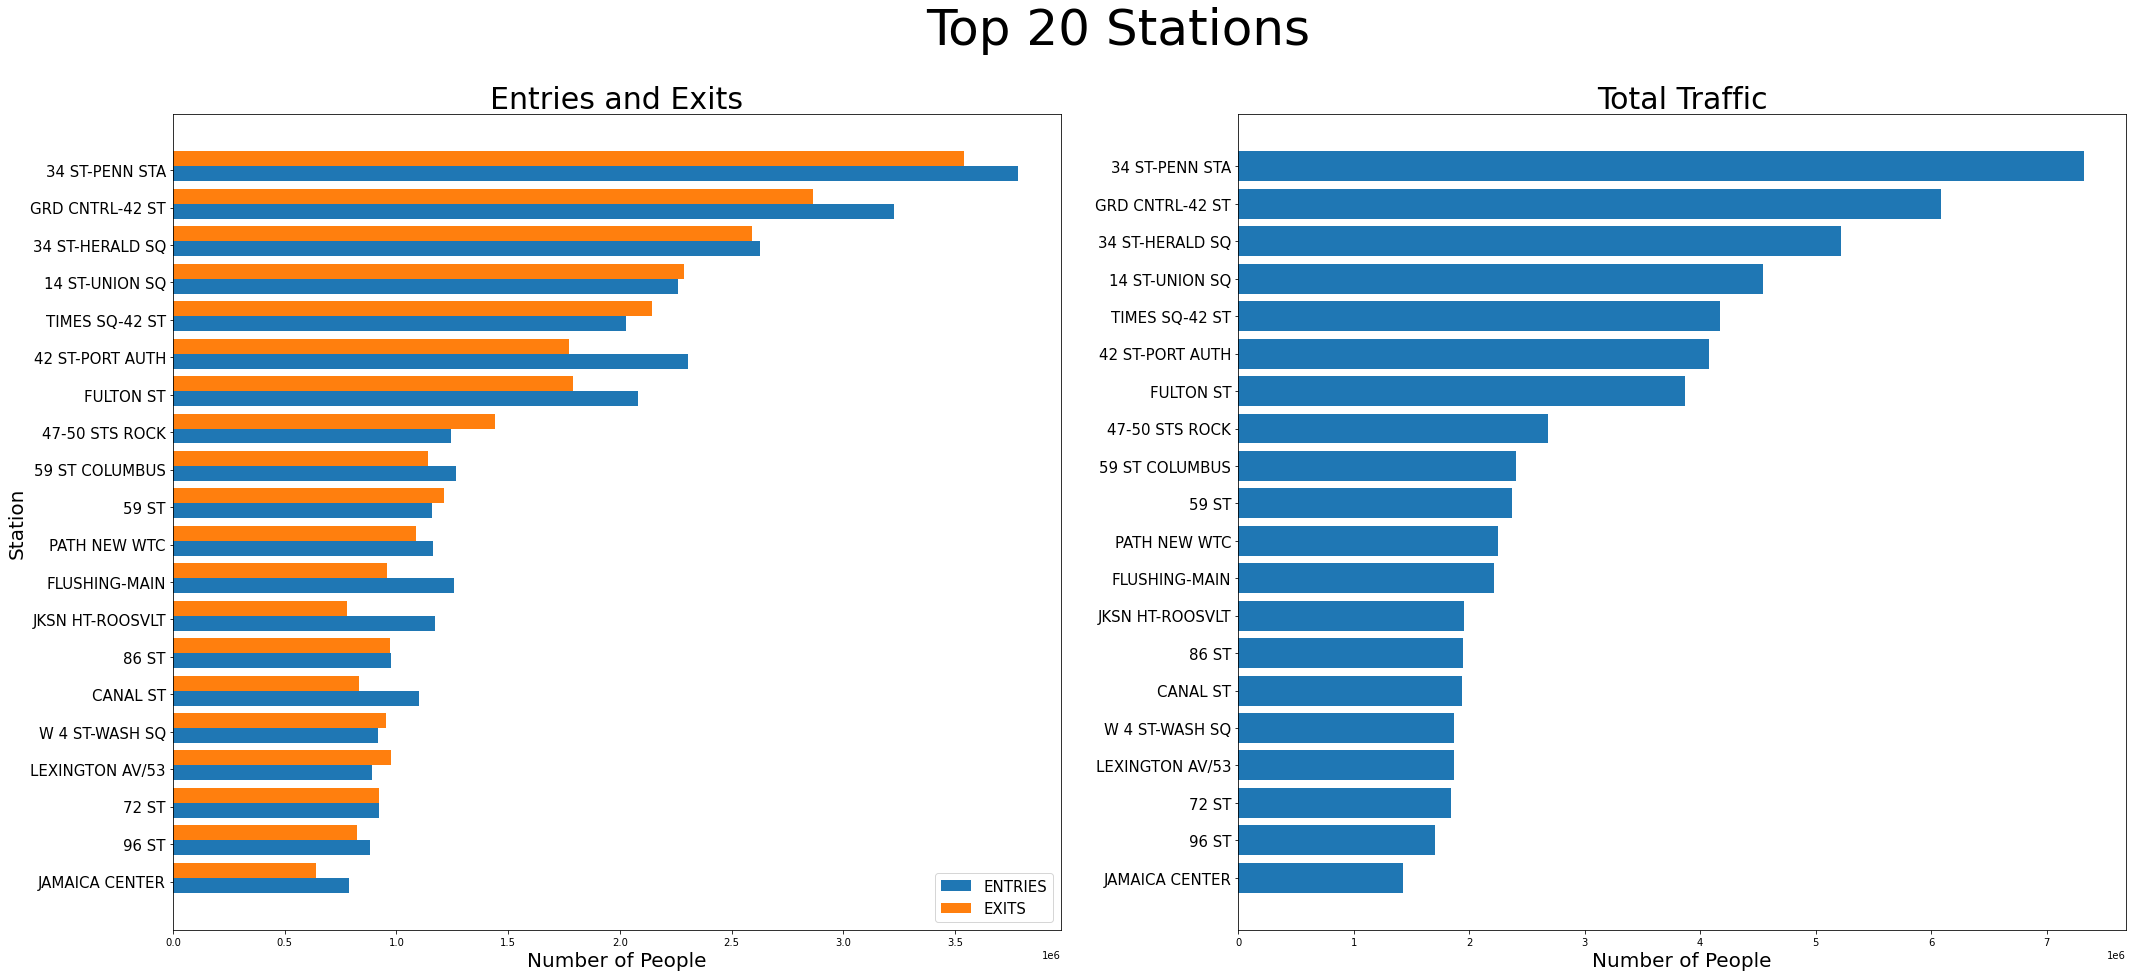

In [47]:
# create the horizontal bar graphs of Entries/Exits and Total Traffic
plt.figure(figsize = [35,15])
plt.suptitle('Top 20 Stations', fontsize=50)
plt.subplot(1,2,1)
plt.barh(Entries,mta_final_graph['ENTRIES'])
plt.barh(Exits,mta_final_graph['EXITS'])
plt.yticks(location, y_ticks, fontsize=15)
plt.legend(['ENTRIES','EXITS'], fontsize = 15)
plt.title('Entries and Exits', fontsize=30)
plt.xlabel('Number of People', fontsize=20)
plt.ylabel('Station', fontsize=20);
plt.subplot(1,2,2)
plt.barh(mta_final_graph['STATION'],mta_final_graph['TotalTraf'])
plt.title('Total Traffic', fontsize=30)
plt.yticks(fontsize=15)
plt.xlabel('Number of People', fontsize=20)
plt.savefig('Top 20 Stations Separate');